# Response analysis


##### 1. Response expression differential analysis - 
twice: (1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

##### 2. Response association with clusters analysis - 
Each cluster see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.

##### 3. GEP association with response (1) -
Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

##### 4. GEP association with response (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic, transpose, bold
from general_helpers import create_folder
from scipy.stats import ranksums, wilcoxon
from shutil import copyfile
import matplotlib.pyplot as plt
import random
from utilities.clustering_tools import find_marker_genes_in_cluster, find_markers_in_clusters
from utilities.clustering_tools import multipletests_fdr

Helper functions:

In [2]:
def print_pvals(pvals, n_groups):
    
    pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, n_groups+1)])], columns=['pval', 'group'])
    plt.figure(figsize=(8, 6), dpi=80);

    pvals = pvals_df[["group", "pval"]].values
    small_pvals = pvals[pvals[:,1]<0.05]
    big_pvals = pvals[pvals[:,1]>=0.05]


    plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1]);
    plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1]);

    ax = plt.plot([0,n_groups+1],[0.05,0.05], color='y');
    plt.xticks(np.arange(1, n_groups+1));
    plt.yticks([0.05, 1]);
    plt.xlim((0,n_groups+1));
    plt.title('p-values');

    for coord in pvals:
        plt.text(coord[0], coord[1], '{}'.format(int(coord[0])));

##### Loads clinical table to get labels - R/NR

In [3]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

In [4]:
melanoma_clinical_data.head(5)

,Patient id,Clinical response,response
0,M97,R,R
1,M98,R (had a response in 2016-2019),R
2,M99,NR (PD),NR
3,M100,NR (SD),NR
4,M101,NED- 10/5/20,R


In [5]:
# melanoma_clinical_data

#### Builds response/non_response sample list

In [6]:
response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'R']['Patient id'].tolist()
non_response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'NR']['Patient id'].tolist()
no_used_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'not in use for now']['Patient id'].tolist()

print(f'number reponse_samples: {len(response_samples)}')
print(f'number non_reponse_samples: {len(non_response_samples)}')
print(f'number no label samples: {len(no_used_samples)}')

number reponse_samples: 14
number non_reponse_samples: 25
number no label samples: 7


#### Loads cohort's myeloid cells:

In [6]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/myeloid_normalized_26.6.21.pkl'

# tumor_cohort = pickle.load(open(tumor_path, 'rb'))
cohort = pickle.load(open(COHORT_PATH, 'rb'))

# Myeloid clustering - Response association with clusters analysis

For each cluster, see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [8]:
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/11.8.21/myeloid_kmeans_11.8.21_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

###### cluster visualizations

In [9]:
df = clusters_barcodes_mapping_df.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [10]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


RanksumsResult(statistic=-0.6894826131275873, pvalue=0.490519611041511)
WilcoxonResult(statistic=20.0, pvalue=0.2783203125)


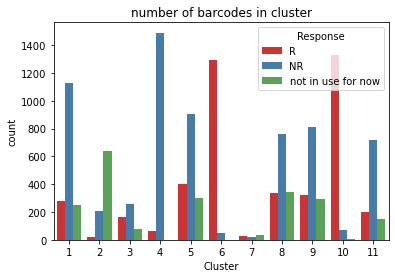

In [11]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Response', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

##### Normalized by group size (number of barcodes in group - R/NR):

Normalized by number of barcodes in group (R/NR):

RanksumsResult(statistic=-0.2954925484832517, pvalue=0.7676176438012221)
WilcoxonResult(statistic=22.0, pvalue=0.365234375)


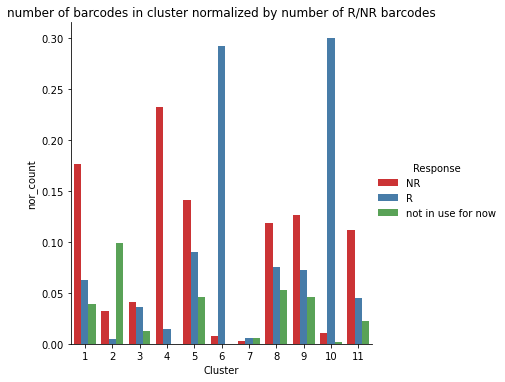

In [12]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
    
print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=-1.4117977316422026, pvalue=0.15800952657623402)
WilcoxonResult(statistic=21.0, pvalue=0.3203125)


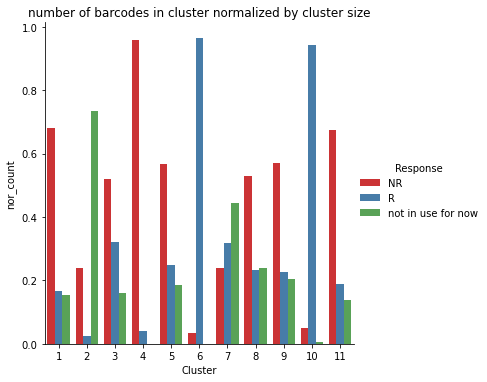

In [13]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

# print('Normalized by number of barcodes in cluster:')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
    
df_nor_count = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
# df_nor_count = df[df["Response"]!= 'not in use for now'].groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### patient fraction over clusters

In [14]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['index', 'Cluster'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

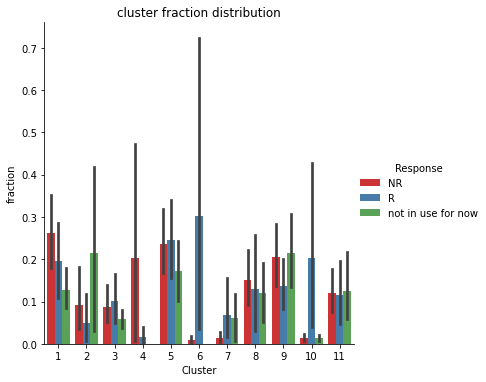

In [15]:
sns.reset_orig()
ax = sns.catplot(kind="bar", x='Cluster', y='fraction', hue='Response', data=sample_fractions_df, palette="Set1").set(title="cluster fraction distribution")

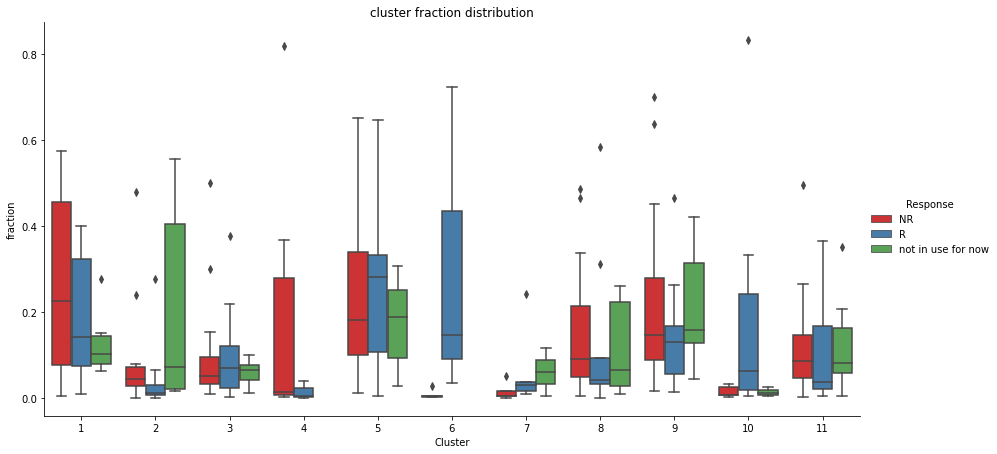

<Figure size 480x240 with 0 Axes>

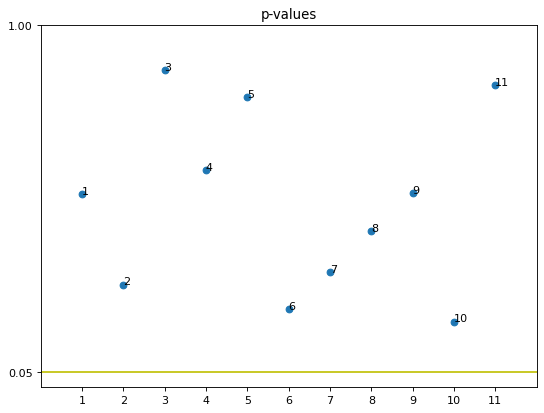

In [16]:
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Response', data=sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")

#####

plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = sample_fractions_df[sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], 11)
# pvals

See how many samples (R/NR) have cells in each cluster:

In [17]:
# sample_fractions_df[["Sample", 'Cluster', 'Response']].groupby(['Cluster','Response']).count()

zero fraction samples have been added:

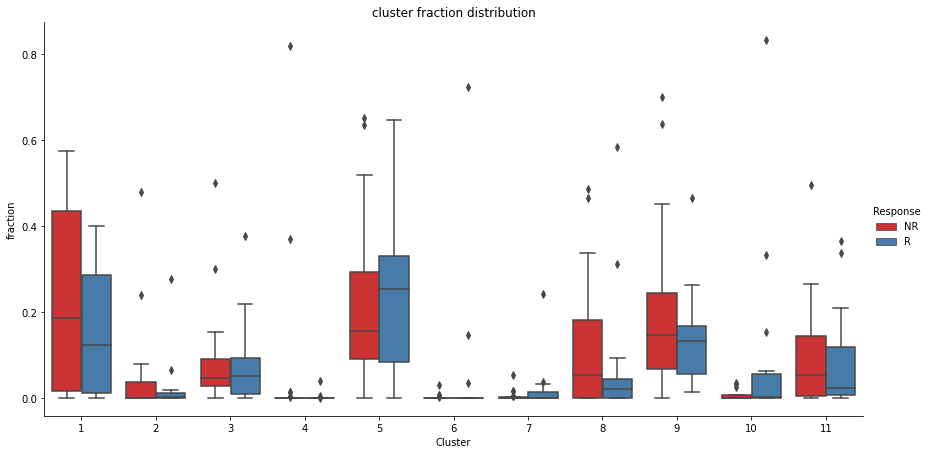

<Figure size 480x240 with 0 Axes>

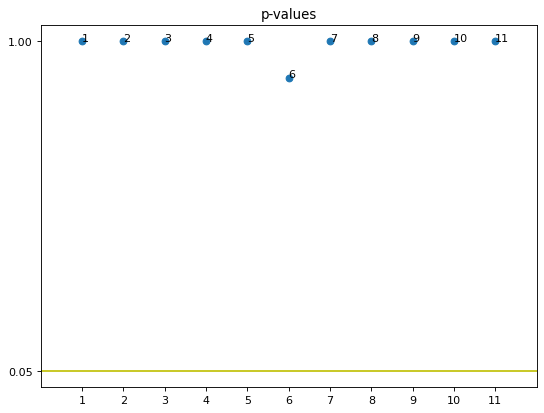

In [18]:
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Response', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], 11)
# pvals

# CD8 clustering - Response association with clusters analysis

For each cluster, see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [19]:
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/11.8.21/CD8_kmeans_11.8.21_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

###### cluster visualizations

In [20]:
df = clusters_barcodes_mapping_df.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [21]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


RanksumsResult(statistic=-0.680336051416609, pvalue=0.49629170223109287)
WilcoxonResult(statistic=21.0, pvalue=0.556640625)


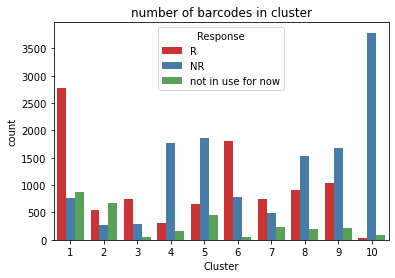

In [22]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Response', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

##### Normalized by group size (number of barcodes in group - R/NR):

Normalized by number of barcodes in group (R/NR):

RanksumsResult(statistic=-0.07559289460184544, pvalue=0.9397429895770734)
WilcoxonResult(statistic=26.0, pvalue=0.921875)


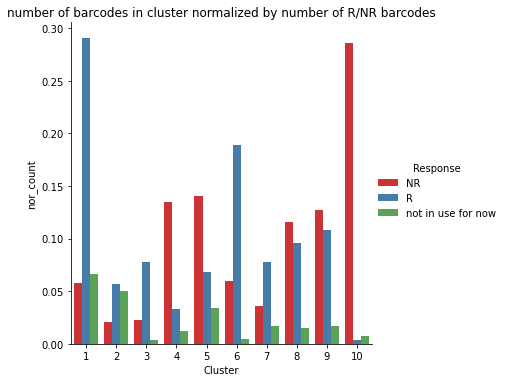

In [23]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
    
print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=-0.5291502622129182, pvalue=0.5967012167293563)
WilcoxonResult(statistic=24.0, pvalue=0.76953125)


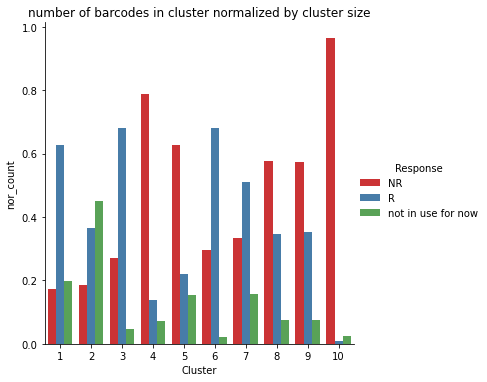

In [24]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

# print('Normalized by number of barcodes in cluster:')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
    
df_nor_count = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
# df_nor_count = df[df["Response"]!= 'not in use for now'].groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### patient fraction over clusters

In [25]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['index', 'Cluster'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

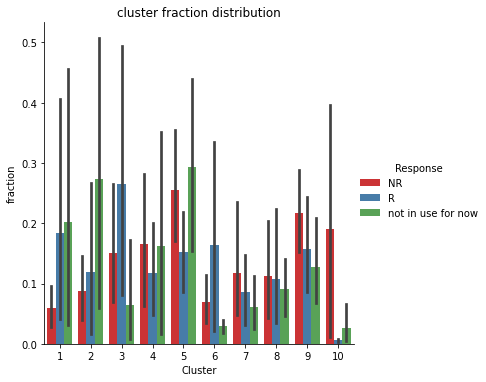

In [26]:
sns.reset_orig()
ax = sns.catplot(kind="bar", x='Cluster', y='fraction', hue='Response', data=sample_fractions_df, palette="Set1").set(title="cluster fraction distribution")

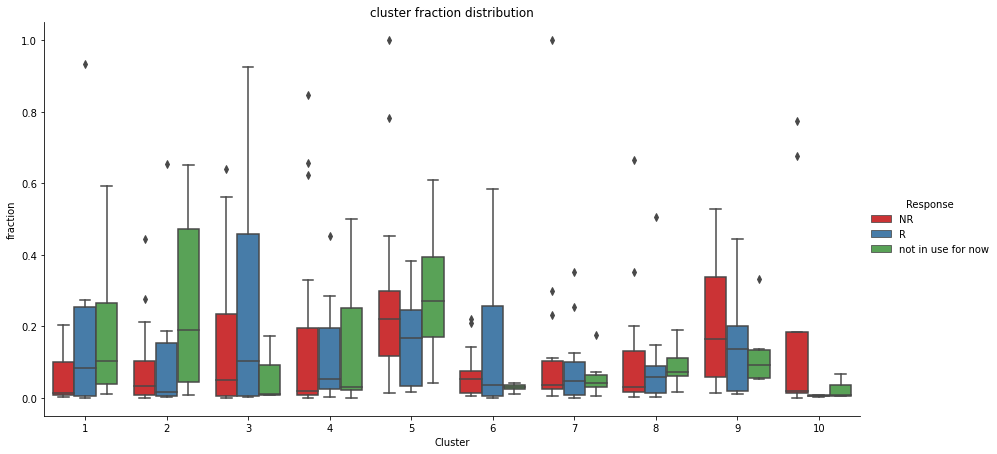

<Figure size 480x240 with 0 Axes>

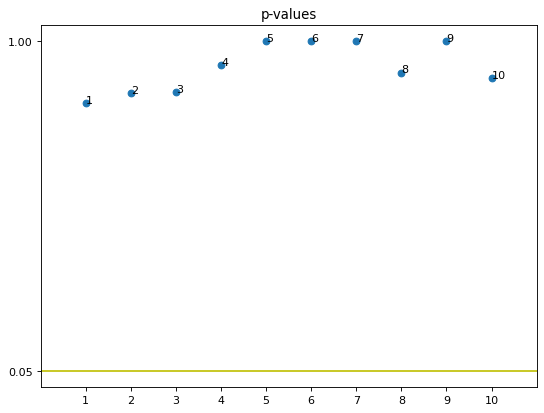

In [27]:
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Response', data=sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")


#########
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = sample_fractions_df[sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], 10)
# pvals

See how many samples (R/NR) have cells in each cluster:

In [28]:
# sample_fractions_df[["Sample", 'Cluster', 'Response']].groupby(['Cluster','Response']).count()

zero fraction samples have been added:

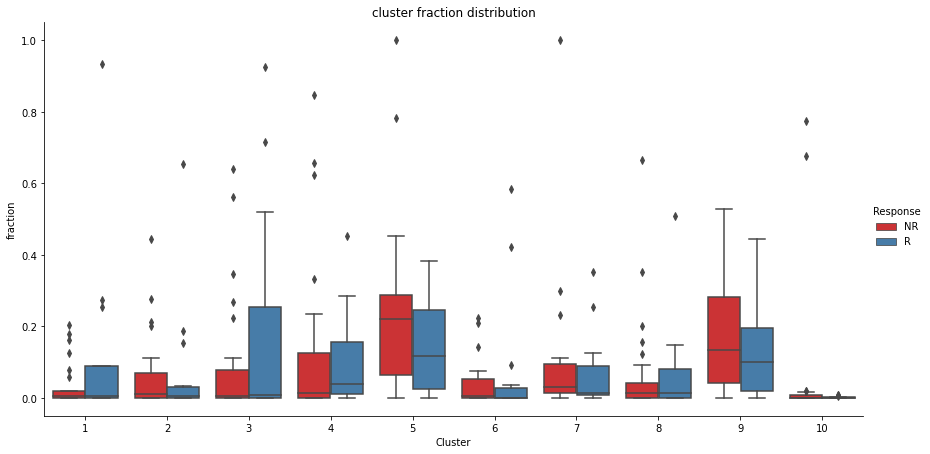

<Figure size 480x240 with 0 Axes>

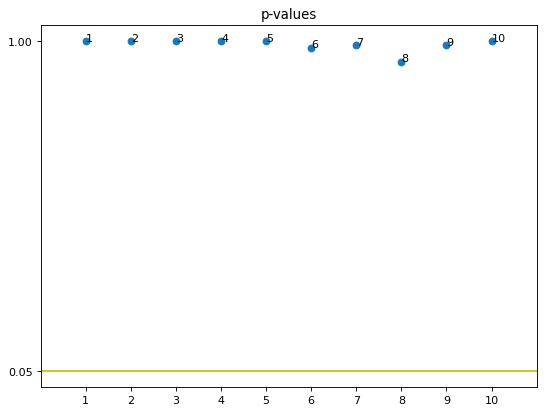

In [30]:
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Response', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], 10)
# pvals

In [31]:
# pvals

In [32]:
# full_sample_fractions_df[full_sample_fractions_df['Cluster']==3].sort_values('fraction')

## Examining siginificance difference with differnt values of K in CD8:

CD8 clustering
K=2


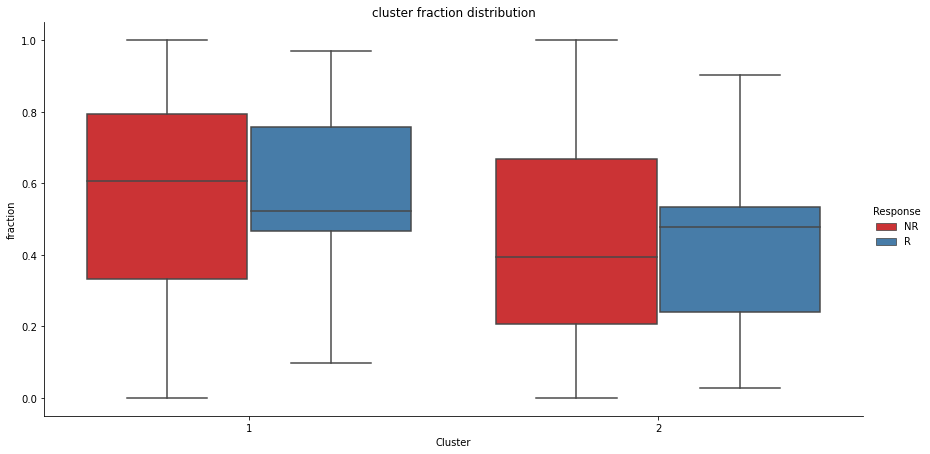

<Figure size 480x240 with 0 Axes>

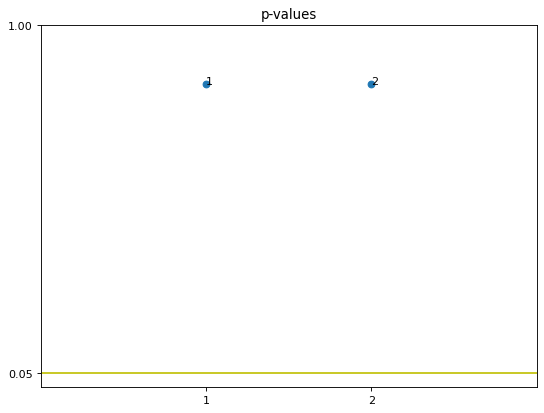

In [10]:
# select K
K = 2
folder = 'CD8'


print(f'{folder} clustering')
print(f'K={K}')
clusters_barcodes_mapping_path = fr'/storage/md_keren/shitay/outputs/clustering/{folder}/kmeans/cohort_26.6.21_run_11.8.21/barcode_mapping/kmeans_immune_cells_4k_genes_k_{K}_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

df = clusters_barcodes_mapping_df.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']


clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index().drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['index', 'Cluster'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])



full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Response', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)


##################################################
################# Correct pvals ##################
##################################################

# pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], K)
# pvals

# Debug

In [24]:
# df

In [22]:
pairs_need_to_add

[['M123', 2], ['M127', 2], ['M128', 2]]

In [ ]:
# for sample, cluster in pairs_need_to_add:
#     full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, 0, 0, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))